In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import shutil
import tensorflow as tf
from tensorflow import keras
from patchify import patchify, unpatchify
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.callbacks import EarlyStopping

from functions import load_data, displaying_images, matching_masks, padder, roi_image, preprocess_data, f1, iou, simple_unet_model, loss_plot, accuracy_plot, predict_all

2024-01-24 23:36:30.337815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-24 23:36:30.337890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-24 23:36:30.339833: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-24 23:36:30.349168: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_folder =  'Dataset/train'
test_folder = 'Dataset/test'
masks_folder = 'Masks'

train_masks_folder = 'train_masks'
test_masks_folder = 'test_masks'
images_with_no_masks_folder = 'images_with_no_masks'

In [3]:
images_train = load_data(train_folder, type='.png')
images_test = load_data(test_folder, type='.png')
masks_train = load_data(train_masks_folder, type='.tif', part='seed')
masks_test = load_data(test_masks_folder, type='.tif', part='seed')

In [4]:
patch_size = 256

X_train, y_train = preprocess_data(images_train, masks_train, patch_size)
X_test, y_test = preprocess_data(images_test, masks_test, patch_size)

In [5]:
print(f"Shape of train images: ", X_train.shape)
print(f"Shape of test images: ", X_test.shape)
print(f"Shape of train seed masks: ", y_train.shape)
print(f"Shape of test seed masks: ", y_test.shape)

Shape of train images:  (7502, 256, 256, 1)
Shape of test images:  (2541, 256, 256, 1)
Shape of train seed masks:  (7502, 256, 256, 1)
Shape of test seed masks:  (2541, 256, 256, 1)


In [6]:
n_classes = 1

In [7]:
model = simple_unet_model(n_classes, patch_size, patch_size, 1)

2024-01-24 23:37:36.932872: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-24 23:37:36.975956: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14056 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-01-24 23:37:36.976525: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-24 23:37:37.047994: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1803 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6
2024-01-24 23:37:37.048315: W tensorflow/core/common_runt

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [8]:
cb = EarlyStopping(monitor='val_loss',
                   patience=2,
                   restore_best_weights='True',
                   mode='min')

history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[cb])

Epoch 1/50


2024-01-24 23:37:48.216335: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-24 23:37:50.669982: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-01-24 23:37:57.923303: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f146cf3d9a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-24 23:37:57.923347: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-24 23:37:57.923355: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-24 23:37:57.923363: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA RTX A6000, Compute Capa

469/469 [==============================] - 113s 162ms/step - loss: 0.0030 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 0.9549 - val_loss: 0.0016 - val_accuracy: 0.9999 - val_f1: 0.0000e+00 - val_iou: 0.9678
Epoch 2/50
469/469 [==============================] - 44s 95ms/step - loss: 0.0011 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 0.9656 - val_loss: 8.1298e-04 - val_accuracy: 0.9999 - val_f1: 0.0000e+00 - val_iou: 0.9678
Epoch 3/50
469/469 [==============================] - 44s 94ms/step - loss: 9.3599e-04 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 0.9656 - val_loss: 7.9736e-04 - val_accuracy: 0.9999 - val_f1: 0.0000e+00 - val_iou: 0.9678
Epoch 4/50
469/469 [==============================] - 44s 93ms/step - loss: 9.1100e-04 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 0.9656 - val_loss: 7.8461e-04 - val_accuracy: 0.9999 - val_f1: 0.0000e+00 - val_iou: 0.9678
Epoch 5/50
469/469 [==============================] - 44s 95ms/step - loss: 8.9213e-04 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 0.9

In [9]:
loss, acc, f1, iou = model.evaluate(X_test, y_test, batch_size=8)

318/318 [==============================] - 15s 25ms/step - loss: 7.0737e-04 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 0.9678


In [10]:
model.save('seed_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


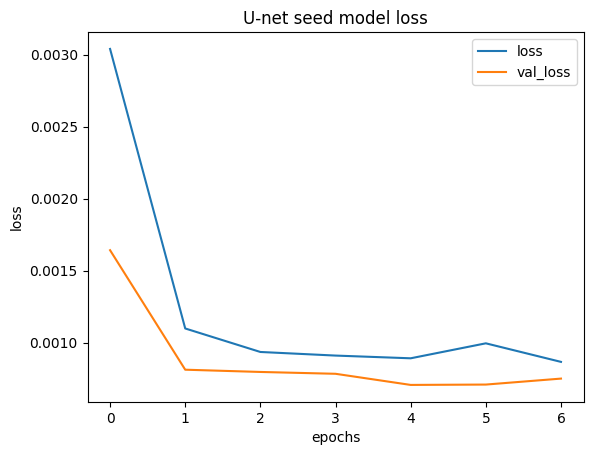

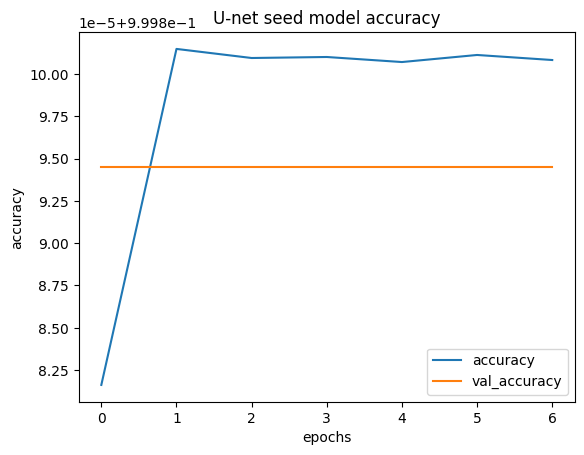

In [11]:
loss_plot(history, "U-net seed model loss")
accuracy_plot(history, "U-net seed model accuracy")

In [12]:
predictions = predict_all(images_test, model, patch_size)

4/4 [==============================] - 1s 30ms/step


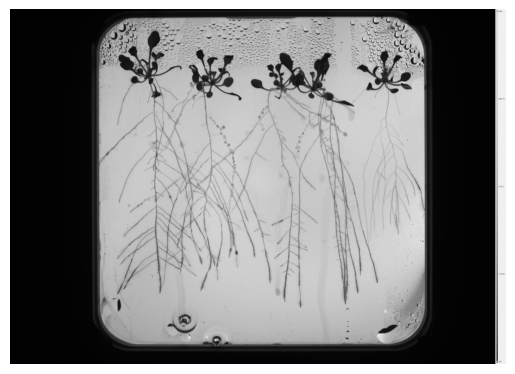

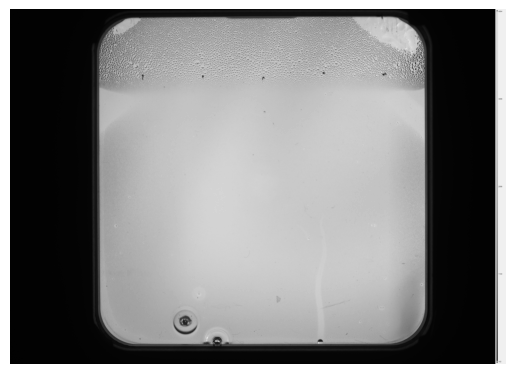

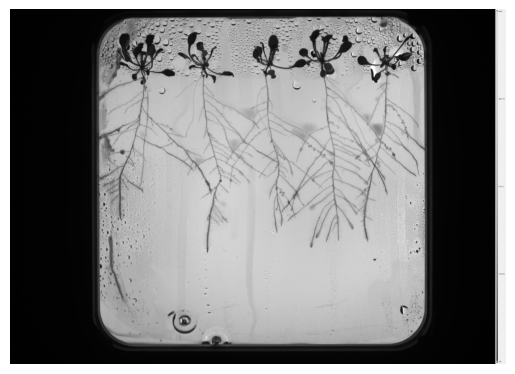

In [13]:
displaying_images(images_test, 3)

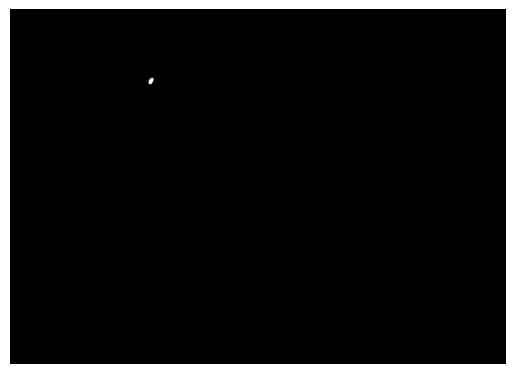

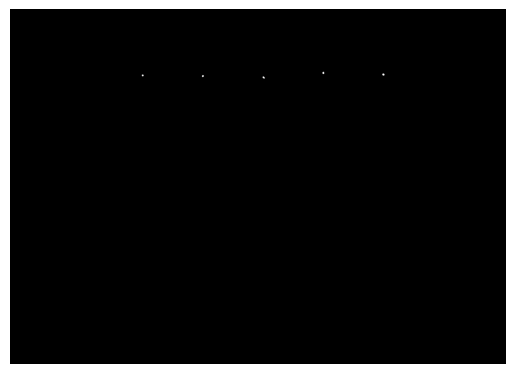

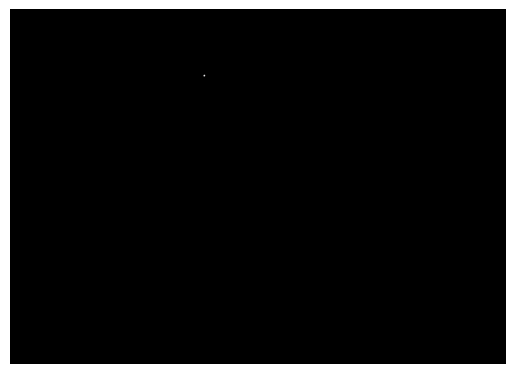

In [14]:
displaying_images(masks_test, 3)

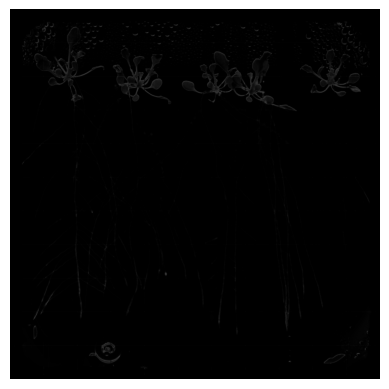

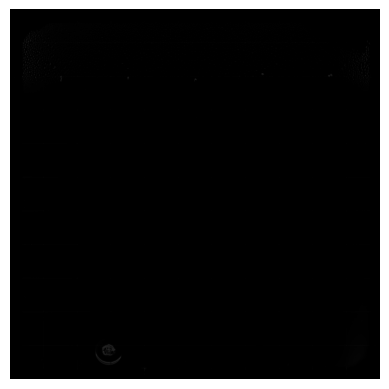

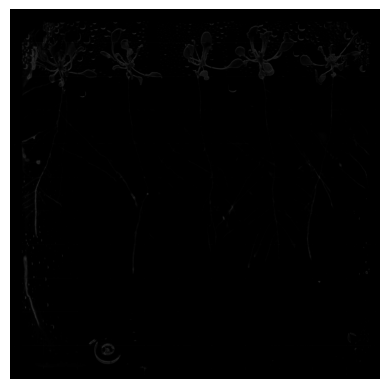

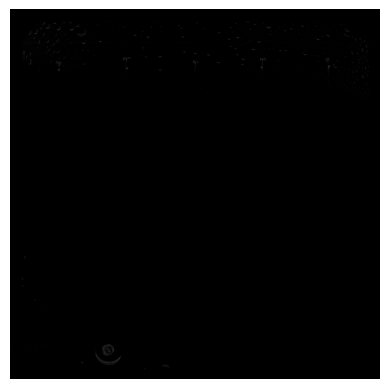

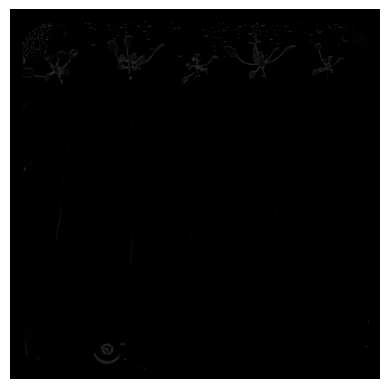

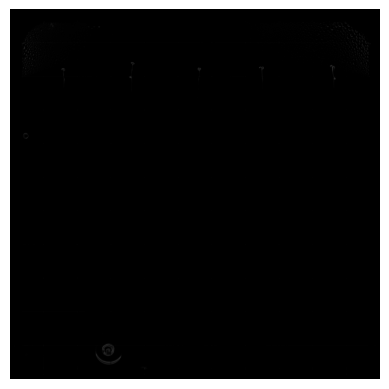

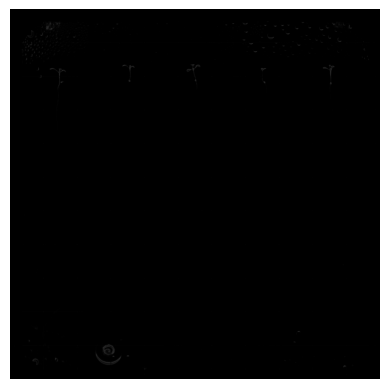

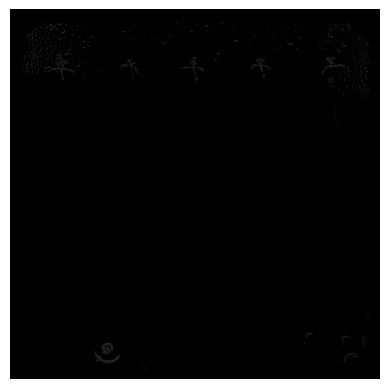

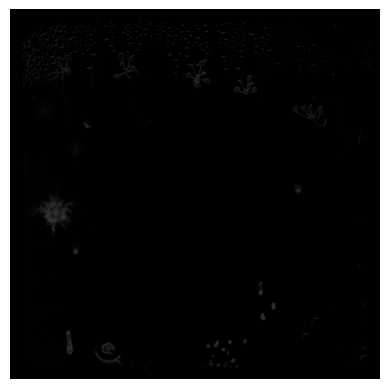

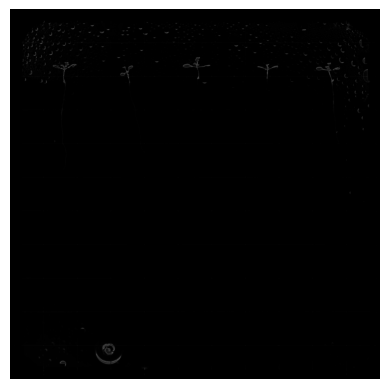

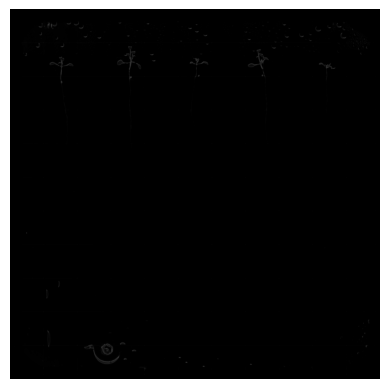

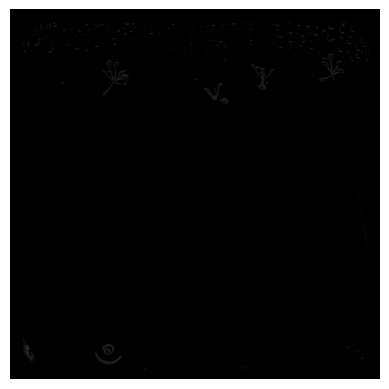

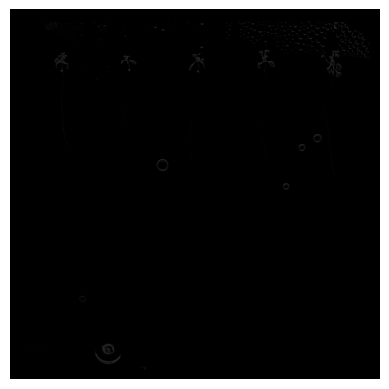

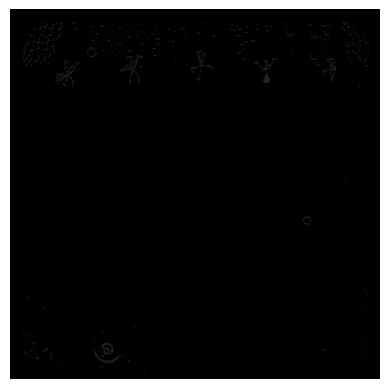

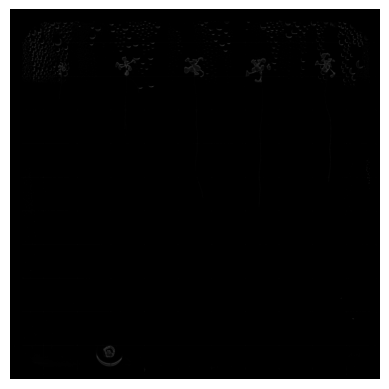

In [15]:
displaying_images(predictions, 15)